In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [3]:
df_train = pd.read_csv('./anomaly_detection_dataset_2022/trainset.csv')
df_anomaly = pd.read_csv('./anomaly_detection_dataset_2022/anomaly_testset2.csv')

df_train = df_train.drop(columns=['created_at'])
df_anomaly = df_anomaly.drop(columns=['created_at', 'scene', 'label'])

# i will assume that the intervales between each row is constant.
# consider interpolating 
# df_train.interpolate(method='time', inplace=True)
df_train.shape, df_anomaly.shape

((45395, 18), (2880, 18))

In [4]:
df_train.columns

Index(['Air1_0013A20041A77E1F/dust', 'Air1_0013A20041A77E1F/humid',
       'Air1_0013A20041A77E1F/temp', 'Air2_0013A20041C54517/dust',
       'Air2_0013A20041C54517/humid', 'Air2_0013A20041C54517/temp',
       'Air3_0013A20041C53D79/humid', 'Air3_0013A20041C53D79/temp',
       'CO2Sensor2_0013A20041C37EB3/CO2', 'CO2Sensor3_0013A20041C53D7D/CO2',
       'Move1_0013A20041C53D71/movement_value',
       'Sound1_0013A20041C53DE3/brightness', 'Sound1_0013A20041C53DE3/sound',
       'Sound2_0013A20041C53CC2/brightness', 'Sound2_0013A20041C53CC2/sound',
       'Sound3_0013A20041C53DA3/brightness', 'Sound3_0013A20041C53DA3/sound',
       'human_detector_D8C0A69B3239/human_num'],
      dtype='object')

In [5]:
column = 'CO2Sensor2_0013A20041C37EB3/CO2'
normal_sensor_data = df_train[column]
abnormal_sensor_data = df_anomaly[column]
normal_sensor_data.shape, abnormal_sensor_data.shape

((45395,), (2880,))

In [6]:
# insert very bad value in abnormal_sensor_data
# a sudden jump to 100%
abnormal_sensor_data.at[1500] = 100

In [7]:
model = ARIMA(normal_sensor_data, order=(1,1,1))
model_fit = model.fit()

In [8]:
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:     CO2Sensor2_0013A20041C37EB3/CO2   No. Observations:                45395
Model:                              ARIMA(1, 1, 1)   Log Likelihood             -171421.649
Date:                             Wed, 03 Jul 2024   AIC                         342849.297
Time:                                     22:23:00   BIC                         342875.467
Sample:                                          0   HQIC                        342857.532
                                           - 45395                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0083      0.002     -3.615      0.000      -0.013      -0.004
ma.L1         -0.5275      

In [9]:
window_size = 100

forecast_data = pd.DataFrame(
    columns=['forecast', 'conf_int_lb', 'conf_int_ub'],
    index=abnormal_sensor_data.index
)

for i in range(len(abnormal_sensor_data) - window_size):
    window = abnormal_sensor_data[i:i+window_size]

    # maintains the parameters of the model, but will forecast given the window data.
    model_window_fit = model_fit.apply(window)

    prediction = model_window_fit.get_forecast(steps=1)

    forecasted = prediction.predicted_mean.to_numpy()[0]
    conf_int = prediction.conf_int(alpha=0.001)
    conf_int = conf_int.to_numpy().flatten()
    
    forecast_data.at[i + window_size + 1, 'forecast'] = forecasted
    forecast_data.at[i + window_size + 1, 'conf_int_lb'] = conf_int[0]
    forecast_data.at[i + window_size + 1, 'conf_int_ub'] = conf_int[1]

last_index = forecast_data.index[-1]
forecast_data = forecast_data.dropna().drop(last_index)

In [10]:
truncated = abnormal_sensor_data[window_size+1:]
detected_data = truncated[(truncated > forecast_data['conf_int_ub'].to_numpy()) | (truncated < forecast_data['conf_int_lb'].to_numpy())]

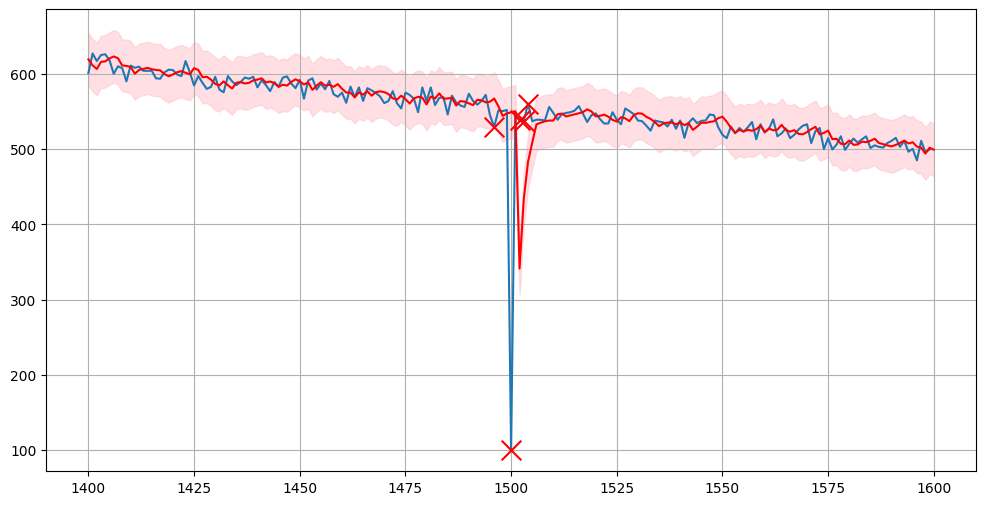

In [15]:
trim_start = 1400
trim_length = 200

plt.figure(figsize=(12,6))
plt.plot(abnormal_sensor_data[trim_start: trim_start + trim_length])

plt.plot(forecast_data['forecast'].loc[trim_start: trim_start + trim_length], c='red')
x = forecast_data['conf_int_lb'].loc[trim_start: trim_start + trim_length].index
lbs = pd.to_numeric(forecast_data['conf_int_lb'].loc[trim_start: trim_start + trim_length])
ubs = pd.to_numeric(forecast_data['conf_int_ub'].loc[trim_start: trim_start + trim_length])
plt.fill_between(x, lbs, ubs, color='pink', alpha=0.5)


detected_data_y = detected_data.loc[trim_start: trim_start + trim_length]
plt.scatter(detected_data_y.index, detected_data_y, marker='x', c='red', s=200, zorder=10)
# plt.axhline(y=normal_sensor_data.mean(), color='r', linestyle='--')

plt.grid(True)
plt.show()

In [114]:
x = forecast_data['conf_int_lb'].loc[trim_start: trim_start + trim_length].index
x.to_numpy()
pd.to_numeric(forecast_data['conf_int_lb'].loc[trim_start: trim_start + trim_length])

101    481.683169
102    480.814012
103    471.742066
104    474.928182
105    478.610597
          ...    
186    442.957060
187    438.232053
188    437.053882
189    442.028280
190    444.983568
Name: conf_int_lb, Length: 90, dtype: float64

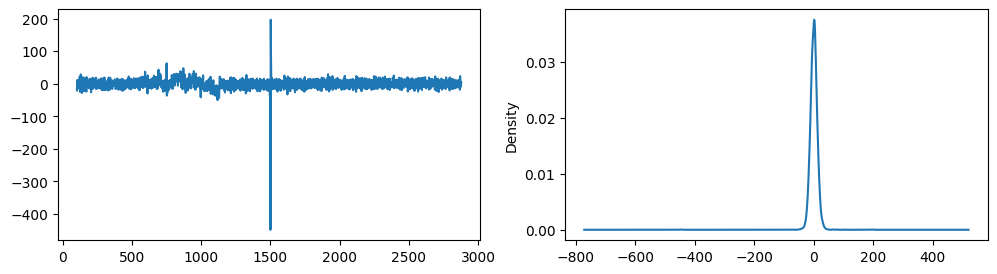

In [16]:
diff = abnormal_sensor_data[window_size:] - forecast_data['forecast']

fig, ax = plt.subplots(1,2, figsize=(12, 3))
diff.plot(ax=ax[0])
diff.plot(kind='kde', ax=ax[1])
plt.show()